Imports and other housekeeping

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import gc

In [3]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d najzeko/steam-reviews-2021

100% 2.96G/2.97G [00:46<00:00, 49.0MB/s]
100% 2.97G/2.97G [00:46<00:00, 69.1MB/s]


In [11]:
!unzip steam-reviews-2021

Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


Important: Please not that for the sake of simplicity of execution and understanding, each Research Question below is independant and does not depend on data loaded or variables calculated in any previous Research Questions. The import of libraries and any other cells above this text still need to be run.

## *RQ1: EDA*

### Basic EDA
Basic EDA is performed on a chunk of main data. The conclusions in basic EDA are assumed to hold for complete main data

Load sample dataset

In [1]:
# load smaller chunk (~4 million rows) of main dataset for basic EDA.

chunksize = 4000000
dataset = pd.read_csv('steam_reviews.csv', nrows = chunksize)

NameError: ignored

Check attributes in data

In [3]:
dataset.shape[1] #check number of columns

22

In [4]:
dataset.columns #check columns list

Index(['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

Check sample rows/content

In [5]:
#have a cursory look at the data
dataset.head(3)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,0,0.0,0,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,0,0.0,0,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,0,0.0,0,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09


In [6]:
#data types. Assume consistent for larger set as well
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   app_id                          int64  
 1   app_name                        object 
 2   review_id                       int64  
 3   language                        object 
 4   review                          object 
 5   timestamp_created               int64  
 6   timestamp_updated               int64  
 7   recommended                     bool   
 8   votes_helpful                   int64  
 9   votes_funny                     int64  
 10  weighted_vote_score             float64
 11  comment_count                   int64  
 12  steam_purchase                  bool   
 13  received_for_free               bool   
 14  written_during_early_access     bool   
 15  author.steamid                  int64  
 16  author.num_games_owned          int64  
 17  author.num_reviews         

### Basic EDA Report:

The facts in the dataset are the **Game** (app), **User**, and **Review** IDs. The dimensions for the game are it's name and whether it was a free purchase or not. The dimensions for the user are their profile statistics like games owned , playtimes and review activity. The dimensions for the reviews themselves are the language, review time and the vote information.

There are a total of 4 boolean, 5 float, 3 string and 11 integer fields, counting the index. 
3 of the 11 integer fields are actually unix timestamps.

### Advanced EDA

Due to memory constraints on local machine and free services on the cloud (Sagemaker, Colab) , EDA is performed by looping on dataset multiple times*, gathering statistics for each chunk, and then combining those statistics for final report.

*This is less ideal than having higher memory specs, as previous chunk is lost to us and unavailable for further processing if next one is uploaded.

In [7]:
#overall 

null_check = []
total_records = 0

error_records = 0

#define arrays for each analysis target

app_name = []
language = []
recommendation = []


chunksize = 1000000


#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize):
  total_records += datachunk.shape[0]
  error_records += datachunk[datachunk.steam_purchase == datachunk.received_for_free].shape[0]
  null_check.append(datachunk.isna().sum())
  app_name.append(datachunk.app_name.value_counts())
  language.append(datachunk.language.value_counts())
  recommendation.append(datachunk.recommended.value_counts())



Bonus data was also tried, but a datatype warning while loading showed problems with data entries (intentional or unintentional) that were taking time to solve in future excercises. (was not simply a datatype conversion). So incorporation of Bonus data was dropped

**Total Size of Dataset**

In [8]:
print('Total records in dataset :', total_records)

Total records in dataset : 21747371


**Suspicious Records**


Records where the 'Steam Purchase' and 'Received for free' flags were the same, since logically you cannot buy a game and receive it free too, or vice versa; you cannot both not buy a game and not receive it for free

In [9]:
print('Suspicious records in dataset:', error_records)
print('Percentage of total:', error_records*100/total_records)

Suspicious records in dataset: 4874918
Percentage of total: 22.416125608929924


This is a surprisingly high number. 
Gather more data understanding: Need further discussion with TAs/Professor/Owner of data, as to reason why both these values could be same.

For now, for any analysis in Research questions, we cannot discard these as this is too high a percentage.

**Percentage of nulls in each column**



Nulls are only present in two columns for negligible percentage of records

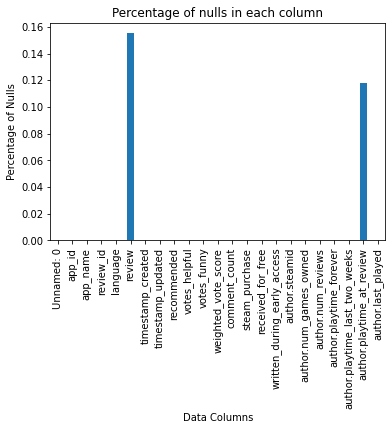

In [10]:
(pd.concat(null_check, axis = 1).sum(axis = 1)*100/total_records).plot.bar(xlabel='Data Columns', ylabel = 'Percentage of Nulls', title= 'Percentage of nulls in each column')

md('Nulls are only present in two columns for negligible percentage of records')

**Games/Applications**

In [11]:
app_values = pd.concat(app_name, axis = 1).sum(axis = 1)
print('Unique Games in dataset: ', app_values.shape[0])
print('Game with highest records: ', app_values.idxmax(),'with', int(app_values.max()), 'records')
print('Game with highest records: ', app_values.idxmin(),'with', int(app_values.min()), 'records')


Unique Games in dataset:  315
Game with highest records:  PLAYERUNKNOWN'S BATTLEGROUNDS with 1644255 records
Game with highest records:  Neon Hardcorps with 200 records


The top 20 games make up of about 48 percent of total records

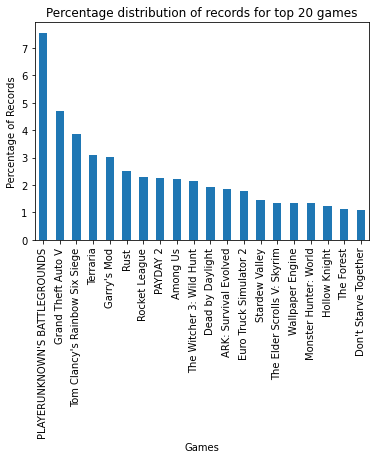

In [12]:
(app_values.sort_values(axis = 0, ascending = False)[:20] * 100 /total_records).plot.bar(xlabel='Games', ylabel = 'Percentage of Records', title ='Percentage distribution of records for top 20 games')
md('The top 20 games make up of about {} percent of total records'.format(round(app_values.sort_values(axis = 0, ascending = False)[:20].sum()*100/total_records),2))

**Languages**

Unique Languages in dataset:  28
Top 3 languages used for reviews:
english     9635437
schinese    3764967
russian     2348900
dtype: int64


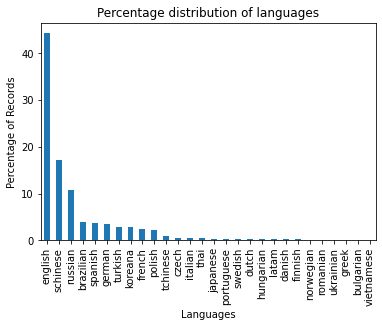

In [13]:
langs = pd.concat(language, axis = 1).sum(axis = 1)
print('Unique Languages in dataset: ', langs.shape[0])

print('Top 3 languages used for reviews:')
print(langs.sort_values(axis = 0, ascending = False)[0:3])
print('==========================================================================================')
(langs.sort_values(axis = 0, ascending = False) * 100 /total_records).plot.bar(xlabel='Languages', ylabel = 'Percentage of Records', title ='Percentage distribution of languages')

**Review Recommendation**

Reviews in this dataset are skewed towards recommending a game


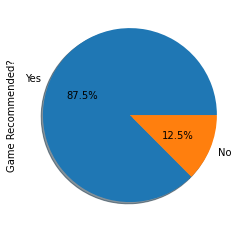

In [14]:
recomm = pd.concat(recommendation, axis = 1).sum(axis = 1).plot.pie(label='Game Recommended?', labels =['Yes', 'No'], shadow = True, autopct='%1.1f%%')

print('Reviews in this dataset are skewed towards recommending a game')

In [ ]:
#clean up

del dataset
gc.collect()

## *RQ2: Simple Insights*

In [18]:
## Loop cell

review_counts = []
max_w_v_score = []
recomm_yes = []
purchase = []

chunksize = 1000000


#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize, 
                             usecols = ['app_name', 'review_id', 'weighted_vote_score', 'recommended','steam_purchase']):
  
  review_counts.append(datachunk.groupby('app_name').review_id.count()) #number of reviews
  max_w_v_score.append(datachunk.groupby('app_name').weighted_vote_score.max()) #maximum weighted score
  recomm_yes.append(datachunk.groupby('app_name').recommended.sum()) #recommendations of purchase
  purchase.append(datachunk.groupby('app_name').steam_purchase.sum()) #purchase_count


77

**Plot the number of reviews for each application in descending order.**

click on plot to zoom in and see


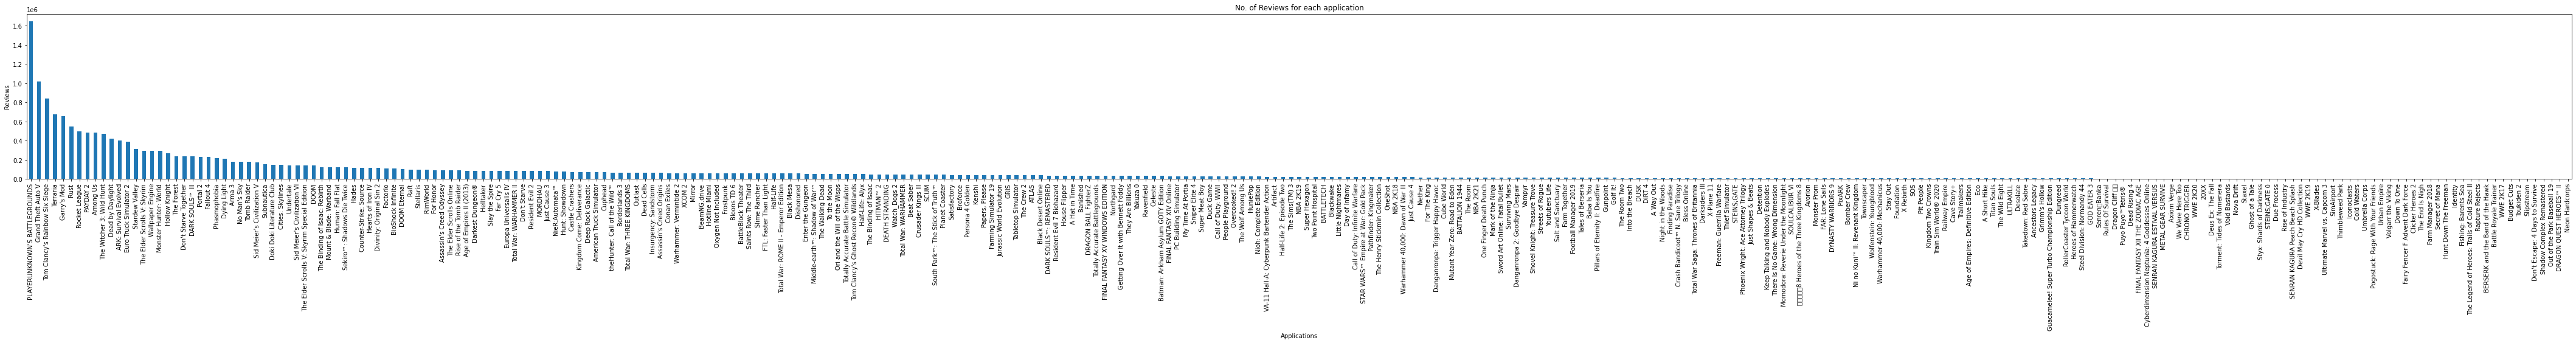

In [19]:
num_reviews = pd.concat(review_counts, axis = 1).sum(axis = 1)
print('click on plot to zoom in and see')
(num_reviews.sort_values(axis = 0, ascending = False)).plot.bar(figsize=(75,5), xlabel='Applications', ylabel = 'Reviews', title ='No. of Reviews for each application')

**What applications have the best Weighted Vote Score?**

In [20]:
max_scores = pd.concat(max_w_v_score, axis = 1).max(axis = 1) #maximum score amongst the maximums of subsets
print('The top 5 applications with the best weighted vote scores in the entire dataset are:')
print(max_scores.sort_values(axis = 0, ascending = False)[0:5])


The top 5 applications with the best weighted vote scores in the entire dataset are:
Stardew Valley              0.995987
Divinity: Original Sin 2    0.995245
Subnautica                  0.994453
Mirror                      0.994038
Wallpaper Engine            0.993540
dtype: float64


**Which applications have the most and the least recommendations?**

In [21]:
yes_recomms = pd.concat(recomm_yes, axis = 1).sum(axis = 1) #total yes recommendations


combined = pd.concat([yes_recomms, num_reviews], axis = 1) #combine review counts and recommendations


print('The top 3 applications with the MOST recommendations are:')
print(yes_recomms.sort_values(axis = 0, ascending = False)[0:3])
print('----------------------------------------------------------------------------------------------------------')
print('The top 3 applications with the MOST recommendations (as a percentage of their review counts)  are:')
print((combined[0]*100/combined[1]).sort_values(axis = 0, ascending = False)[0:3])
print('----------------------------------------------------------------------------------------------------------')
print('The top 3 applications with the LEAST recommendations are:')
print(yes_recomms.sort_values(axis = 0, ascending = True)[0:3])
print('----------------------------------------------------------------------------------------------------------')
print('The top 3 applications with the LEAST recommendations (as a percentage of their review counts)  are:')
print((combined[0]*100/combined[1]).sort_values(axis = 0, ascending = True)[0:3])



The top 3 applications with the MOST recommendations are:
PLAYERUNKNOWN'S BATTLEGROUNDS     886417.0
Grand Theft Auto V                831311.0
Tom Clancy's Rainbow Six Siege    742397.0
dtype: float64
----------------------------------------------------------------------------------------------------------
The top 3 applications with the MOST recommendations (as a percentage of their review counts)  are:
ULTRAKILL       99.534384
Senren＊Banka    99.404052
A Short Hike    99.144861
dtype: float64
----------------------------------------------------------------------------------------------------------
The top 3 applications with the LEAST recommendations are:
Neon Hardcorps              89.0
DRAGON QUEST HEROES™ II    423.0
Identity                   439.0
dtype: float64
----------------------------------------------------------------------------------------------------------
The top 3 applications with the LEAST recommendations (as a percentage of their review counts)  are:
Identity  

**How many of these applications were purchased, and how many were given for free?**

For this question, suspicious records  where "purchase" and "free" indicators are both the same, we consider "purchase" indicator as authentic. i.e. If purchase is true, that is considered a purchase, even if received for free is true as well.

In [22]:
num_purchase = pd.concat(purchase, axis = 1).sum(axis = 1) #total purchased
combined = pd.concat([num_purchase, num_reviews], axis = 1) #combine review counts and purchase counts

print('Total purchased applications:', combined[0].sum(), "({} %)".format(combined[0].sum()*100/combined[1].sum()))
print('Total given for free:', combined[1].sum() - combined[0].sum() , "({} %)".format((combined[1].sum() - combined[0].sum())*100/combined[1].sum()))


Total purchased applications: 16842432.0 (77.44583011896013 %)
Total given for free: 4904939.0 (22.554169881039872 %)


## *RQ3: Time of Reviews*

**What is the most common time that authors review an application?**



In [29]:
def get_review_frequency():

  #this function reads the steam dataset and 
  #outputs a matrix of review counts for each hour, minute, and second of the day


  def date_conv(unix_d):
    return pd.to_datetime(unix_d, unit = 's')


  t_freq_3 = np.zeros((24,60,60))   #review_frequency_3d_matrix

  chunksize = 2000000

  #calculate statistics
  for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize, usecols = ['review_id', 'timestamp_created'],
                              parse_dates=['timestamp_created'], 
                              date_parser=date_conv ):
    
    for ts in datachunk['timestamp_created'].to_list():
      h = ts.hour
      m = ts.minute
      s = ts.second
      t_freq_3[h, m, s] += 1

  return t_freq_3  




In [30]:
t_freq_3 = get_review_frequency() #Frequency of reviews at hour, min and second grain

t_freq_2 = t_freq_3.sum(axis = 2) #since questions asks for common time in hours and mins, roll up this to a 2d matrix

best_time = np.where(t_freq_2 == np.amax(t_freq_2)) #index of maximum value in our 2d matrix

print('The most common time that authors review an application is at ', best_time[0][0], ':', best_time[1][0])
print('The total reviews seen in the data at that time are', int(np.amax(t_freq_2)))


The most common time that authors review an application is at  14 : 50
The total reviews seen in the data at that time are 19502


**Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.**

In [31]:
def plot_reviews(interval_list):
  #input is an list of intervals. The function assumes that each interval in this list
  #is a tuple of size 2 containing initial time and final time in string format
  
  #===================================================================================
  def get_review_frequency():

    #this function reads the steam dataset and 
    #outputs a matrix of review counts for each hour, minute, and second of the day


    def date_conv(unix_d):
      return pd.to_datetime(unix_d, unit = 's')


    t_freq_3 = np.zeros((24,60,60))   #review_frequency_3d_matrix

    chunksize = 2000000
    
    #calculate statistics
    for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize, usecols = ['review_id', 'timestamp_created'],
                                 parse_dates=['timestamp_created'], date_parser=date_conv ):

      datachunk = datachunk.iloc[:,1:] #removing index
      
      for ts in datachunk['timestamp_created'].to_list():
        h = ts.hour
        m = ts.minute
        s = ts.second
        t_freq_3[h, m, s] += 1
      
    return t_freq_3  


  #============================================================================================

  t_freq_3 = get_review_frequency()

  y_arr = [] #array of num reviews. y axis of plot
  x_arr = [] #array of range in x axis
  for timestamps in interval_list:
    start, end = timestamps[0], timestamps[1]
    start_h, start_m, start_s  = map(int, start.split(':'))
    end_h, end_m, end_s  = map(int, end.split(':'))
    y_arr.append(t_freq_3[start_h:end_h+1, start_m:end_m+1, start_s:end_s+1].sum())
    x_arr.append(start + ' to ' + end)
    
 
  plt.figure(figsize=(len(interval_list),5))
  plt.xticks(rotation=90)
  plt.xlabel('Time Intervals')
  plt.ylabel('Number of Reviews')
  plt.bar(x_arr,y_arr)
  plt.show()


**Use the function that you created in the previous literal to plot the number of reviews between the following time intervals**

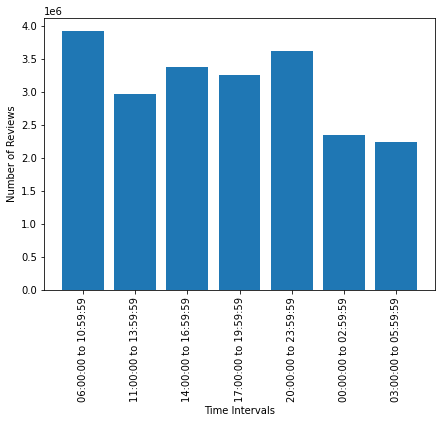

In [32]:

time_list =[('06:00:00', '10:59:59'), ('11:00:00', '13:59:59'), 
            ('14:00:00', '16:59:59'), ('17:00:00', '19:59:59'),
            ('20:00:00', '23:59:59'), ('00:00:00', '02:59:59'),
            ('03:00:00', '05:59:59')]

plot_reviews(time_list)

In [35]:
#clean up
del t_freq_3
del t_freq_2
gc.collect()

3284

## *RQ4: Languages of Reviews*

**What are the top 3 languages used to review applications?**

As already determined in advanced EDA in *RQ1* above (Section: Languages), the top 3 languages used to review applications are:

1.   English
2.   Schinese
3.   Russian



**Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.**

Note: The problem statement asks us to return dataframe filtered only with reviews, but we will also return some additional columns besides the review, like votes_funny and votes_helpful, to make the returned dataframe useful for next parts of the question.

In [5]:
def filter_on_lang(dataset_name, language_list):

  #this function reads a dataset with the dataset name and 
  #outputs a dataframe of reviews with only languages in language list.

  filtered_df = pd.DataFrame()

  chunksize = 2000000

  #calculate statistics
  for datachunk in pd.read_csv(dataset_name, chunksize=chunksize, 
                               usecols =['review_id', 'review','language', 'votes_funny', 'votes_helpful']):
    
    datachunk = datachunk[datachunk.language.isin(language_list)]
    filtered_df = filtered_df.append(datachunk)
    
  return filtered_df


**Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?**

any review with > 0 in "votes_funny" is counted as a funny review

In [6]:
top_3 = ['english', 'schinese', 'russian']
lang_df = filter_on_lang("steam_reviews.csv", top_3)
result = pd.concat([lang_df[lang_df.votes_funny > 0].groupby(['language']).votes_funny.count(),lang_df.groupby(['language']).review_id.count()], axis = 1)
print('Percentage of reviews (for top 3 languages) voted as funny:')
print((result.votes_funny*100/result.review_id))

Percentage of reviews (for top 3 languages) voted as funny:
language
english     11.270864
russian     16.679467
schinese    11.818032
dtype: float64


In [7]:
#clean up
del lang_df
gc.collect()

198

**Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?**

any review with > 0 in "votes_helpful" is counted as a helpful review

In [8]:
top_3 = ['english', 'schinese', 'russian']
lang_df = filter_on_lang("steam_reviews.csv", top_3)
result = pd.concat([lang_df[lang_df.votes_helpful > 0].groupby(['language']).votes_helpful.count(),lang_df.groupby(['language']).review_id.count()], axis = 1)
print('Percentage of reviews (for top 3 languages) voted as helpful:')
print((result.votes_helpful*100/result.review_id))

Percentage of reviews (for top 3 languages) voted as helpful:
language
english     29.203377
russian     35.501554
schinese    25.103992
dtype: float64


In [9]:
#clean up
del lang_df
gc.collect()

330

## *RQ5: Users*

For this question, records where "purchase" and "free" indicators are both the same, we consider "purchase" indicator as source of truth. i.e. If purchase is true, that is considered a purchase, even if received for free is true as well.

**Plot the top 10 most popular reviewers and the number of reviews.**

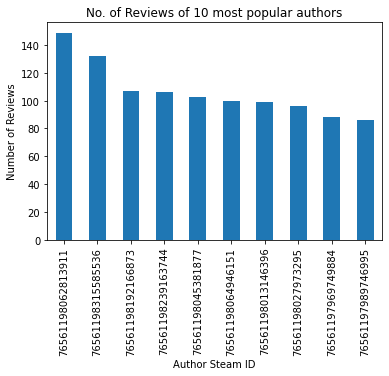

In [50]:
author_data = []

chunksize = 1000000


#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize,
                             usecols = ['author.steamid', 'review_id']):
  author_data.append(datachunk.groupby(['author.steamid']).count())

author_reviews = pd.concat(author_data, axis = 1).sum(axis = 1)

(author_reviews.sort_values(axis = 0, ascending = False)[0:10]).plot.bar(xlabel='Author Steam ID', ylabel = 'Number of Reviews', title ='No. of Reviews of 10 most popular authors')

Now we have the steam ID of the most popular author and can deep dive into further questions about them

In [65]:
pop_user = author_reviews.sort_values(axis = 0, ascending = False)[0:1].index.to_list()[0]  #steam ID for most popular user

In [64]:
#get data for most popular user

chunksize = 1000000

pop_user_df = pd.DataFrame()

#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize,
                             usecols = ['author.steamid', 'app_name', 'received_for_free', 'steam_purchase', 'recommended']):
  pop_user_df = pop_user_df.append(datachunk[datachunk['author.steamid'] == pop_user])



**What applications did the most popular author review?**

In [72]:
print('List of applications reviewd by most popular user:', sorted(list(pop_user_df.app_name.unique())))

List of applications reviewd by most popular user: ['A Hat in Time', 'ARK: Survival Evolved', 'Age of Empires II (2013)', 'Age of Empires: Definitive Edition', 'American Truck Simulator', 'Among Us', 'Ancestors Legacy', 'Axiom Verge', 'Banished', 'BattleBlock Theater', 'BioShock Infinite', 'Black Desert Online', 'Black Mesa', 'Blackwake', 'Bomber Crew', 'Broforce', 'Castle Crashers', 'Cave Story+', 'Celeste', 'Cities: Skylines', 'Conan Exiles', 'Counter-Strike: Source', 'Cuphead', 'DARK SOULS™ III', 'DOOM', 'DOOM Eternal', 'DUSK', 'Darksiders III', 'Day of Infamy', 'Dead Cells', 'Dead Rising 4', 'Dead by Daylight', 'Deep Rock Galactic', 'Devil May Cry HD Collection', 'Dishonored', "Don't Escape: 4 Days to Survive", "Don't Starve", 'Duck Game', 'Dying Light', 'Enter the Gungeon', 'Euro Truck Simulator 2', 'Europa Universalis IV', 'FAR: Lone Sails', 'FTL: Faster Than Light', 'Factorio', 'Fallout 4', 'Finding Paradise', 'Foundation', 'Frostpunk', 'GRIS', "Garry's Mod", 'Getting Over It wi


**How many applications did he purchase, and how many did he get as free?**

In [92]:
purchase_dict  = pop_user_df.steam_purchase.value_counts().to_dict()

print('Count of applications purchased:',purchase_dict[True])
print('Percentage of applications purchased:',round(purchase_dict[True]*100/sum(purchase_dict.values()),2))


print('Count of applications gotten free:',purchase_dict[False])
print('Percentage of applications gotten free:',round(purchase_dict[False]*100/sum(purchase_dict.values()),2))


Count of applications purchased: 110
Percentage of applications purchased: 73.83
Count of applications gotten free: 39
Percentage of applications gotten free: 26.17


**How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?**

In [130]:
pop_user_df.groupby(['steam_purchase','recommended']).app_name.count().to_frame().sort_values(by= ['steam_purchase', 'recommended'], ascending = False).rename(columns = {'app_name':'Number of Applications'})


Number of Applications
steam_purchase recommended                        
True           True                            108
               False                             2
False          True                             38
               False                             1

## *RQ6: Updates to Reviews*

The assumption taken in this exercise is that reviews are updated only if timestamps of creation and update are different

In [134]:
def date_conv(unix_d):
  return pd.to_datetime(unix_d, unit = 's')

total_diff_sec = 0
update_counts = 0

updating_authors = []

chunksize = 2000000

#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize, 
                             usecols = ['author.steamid', 'timestamp_created','timestamp_updated','review_id'],
                            parse_dates=['timestamp_created','timestamp_updated'], 
                            date_parser=date_conv ):
  
  datachunk = datachunk[datachunk.timestamp_updated != datachunk.timestamp_created] #only take data where reviews were updated
  
  updating_authors.append(datachunk.groupby(['author.steamid']).review_id.count())

  for difference in (datachunk['timestamp_updated'] - datachunk['timestamp_created']).to_list():
    total_diff_sec += difference.total_seconds()
    update_counts += 1


SyntaxError: ignored

**What is the average time (days and minutes) a user lets pass before he updates a review?**

In [146]:
avg_sec =  total_diff_sec/update_counts

print('Average time a user lets pass before he updates a review:', int(avg_sec//(24*3600)), 'days and', round(((avg_sec % (24*3600))/60),2), 'minutes') 

Average time a user lets pass before he updates a review: 321 days and 46.41 minutes


**Plot the top 3 authors that usually update their reviews.**


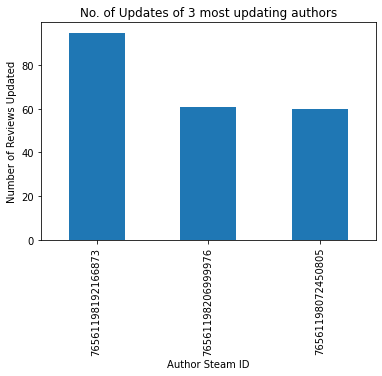

In [148]:

author_updates = pd.concat(updating_authors, axis = 1).sum(axis = 1)

(author_updates.sort_values(axis = 0, ascending = False)[0:3]).plot.bar(xlabel='Author Steam ID', ylabel = 'Number of Reviews Updated', title ='No. of Updates of 3 most updating authors')

## *RQ7: Probabilities*

In [149]:
count_score_big = 0  #count of reviews where weighted score >=0.5
count_one_funny = 0 #count of reviews with atleast one funny vote
count_one_funny_score_big = 0 #count of reviews where weighted score > 0.5 AND atleast one funny vote
count_reviews = 0

chunksize = 2000000

#calculate statistics
for datachunk in pd.read_csv("steam_reviews.csv", chunksize=chunksize, 
                             usecols = ['review_id', 'votes_funny','weighted_vote_score']):
  
  count_reviews += datachunk.shape[0]
  count_score_big += datachunk[datachunk.weighted_vote_score >= 0.5].shape[0]
  count_one_funny += datachunk[datachunk.votes_funny >= 1].shape[0]  
  count_one_funny_score_big += datachunk[(datachunk.votes_funny >= 1) & (datachunk.weighted_vote_score >= 0.5) ].shape[0] 


**What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?**



In [150]:
print('Probability that review has a Weighted Vote Score equal to or bigger than 0.5 =', count_score_big/count_reviews)

Probability that review has a Weighted Vote Score equal to or bigger than 0.5 = 0.21735


**What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?**
   

In [153]:
p_a = count_one_funny/count_reviews
p_b = count_score_big/count_reviews
p_a_and_b = count_one_funny_score_big/count_reviews

p_a_given_b = p_a_and_b/p_b

print('Probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 = ', p_a_given_b)

Probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 =  0.22360938578329884


**Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?**

In [159]:
p_a = count_one_funny/count_reviews
p_b = count_score_big/count_reviews
p_a_and_b = count_one_funny_score_big/count_reviews

print('P(A) => Probability that a review has at least one vote as funny =', p_a)
print('P(B) => Probability that a review has a weighted score equal or bigger than 0.5 =', p_b)
print('P(A and B) => Probability that a review has at least one vote as funny AND has a weighted score equal or bigger than 0.5 =', p_a_and_b)
print('Since P(A and B) != P(A)*P(B), these events are not independant')


P(A) => Probability that a review has at least one vote as funny = 0.1057575
P(B) => Probability that a review has a weighted score equal or bigger than 0.5 = 0.21735
P(A and B) => Probability that a review has at least one vote as funny AND has a weighted score equal or bigger than 0.5 = 0.0486015
Since P(A and B) != P(A)*P(B), these events are not independant


In [ ]:
# Input: 
#     A: array of length n
#     k: integers between 1 and n
    
def alg(A, k):
  s <-- a random element of A
  set L = [all the elements of A with value <= s]
  set R = [all the elements of A with value > s]
  r = len(L)
  if k == r:
    return s
  else if k < r:  
    return alg(L, k)
  else:
    return alg(R, k - r)

In [ ]:
A = [1 7 8 2 10]
k = 4

s = 7
set L = (1 ,2)
set R = (7, 8, 10)

r = 2 (len L )

if k = r (4=2)
  return 7
if k <r (4 < 2)
  alg(L, k)    => alg([1,2], 4)
if k > r
  alg(R, k-r) => alg ([7,8,10], 4-2]
                      

                      


